# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [3]:
var='TSKIN'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')

In [5]:
from load_ensembles import *

In [6]:
keys=crosswalk['Key_short'].values
keys_coupledPPE = crosswalk['key_coupledPPE'].values
keys_landonlyPPE = crosswalk['key_landonlyPPE'].values

In [7]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [8]:
import make_multisimulation_dataset

In [9]:
import quick_map

In [10]:
PRECT=xr.open_dataset('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/EOFs/data/'+
                      'PRECT_delta_Annual.nc')

In [11]:
yvar2=PRECT['__xarray_dataarray_variable__']

# Load data

### Load gridcell info

In [12]:
from esem import gp_model

2023-06-13 15:29:22.904468: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 15:29:22.963363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 15:29:23.956532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
from load_gridcell_areas import *
spin_up_yr=40

In [14]:
path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/'
ds1=xr.open_dataset(path_in+'delta_TSKIN_Annual_mean.nc').TSKIN
ds2=xr.open_dataset(path_in+'delta_calculated_PRECT_Annual_mean.nc').calculated_PRECT

In [15]:
import os
## Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [16]:
import iris
from utils import get_bc_ppe_data

from esem import gp_model
from esem import get_random_params

import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'utils'

In [31]:
d = {"var1": ds1.mean(dim=['lat','lon']), "var2":ds1.mean(dim=['lat','lon'])}
df = pd.DataFrame(d)

In [33]:
df.describe()

,var1,var2
count,36.000000,36.000000
mean,0.028208,0.028208
std,0.175745,0.175745
min,-0.440525,-0.440525
25%,-0.072441,-0.072441
50%,0.028352,0.028352
75%,0.169754,0.169754
max,0.373346,0.373346


In [46]:
X_train=df
Y_train=ds2.mean(dim=['lat','lon'])

In [35]:
model = gp_model(X_train, Y_train)#, kernel=['Linear', 'Cosine'], kernel_op='add')

2023-06-13 15:33:55.730750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [37]:
model.train()

In [38]:
m, v = model.predict(X_train.values)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2b44bb766a60>
Traceback (most recent call last):
  File "/glade/u/home/czarakas/.conda/envs/ESEm/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/glade/u/home/czarakas/.conda/envs/ESEm/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/glade/u/home/czarakas/.conda/envs/ESEm/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/glade/u/home/czarakas/.conda/envs/ESEm/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

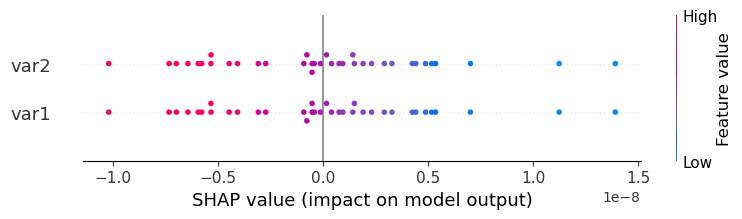

In [47]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct

#X,y = shap.datasets.diabetes()
X_train=X_train
y_train=Y_train
X_test=X_train
y_test=y_train
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_summary = shap.kmeans(X_train, 10)
kernel = DotProduct() + WhiteKernel()

gp = GaussianProcessRegressor(kernel)
gp.fit(X_train, y_train)

explainer = shap.KernelExplainer(gp.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Load and check reference cases

In [434]:
ratio=delta_Ts_coupled/delta_Ts_offline
amplifying_count=(((ratio>=1)&np.isfinite(ratio))*landweights).mean(dim=['lat','lon'])
diminishing_count=(((ratio>=0)&(ratio<1)&np.isfinite(ratio))*landweights).mean(dim=['lat','lon'])
switch_sign_count=(((ratio<0)&np.isfinite(ratio))*landweights).mean(dim=['lat','lon'])
no_offline_change=((delta_Ts_offline==0)*landweights).mean(dim=['lat','lon'])
no_offline_change_butwarms=(((delta_Ts_offline==0)&(ratio>0))*landweights).mean(dim=['lat','lon'])
no_offline_change_butcools=(((delta_Ts_offline==0)&(ratio<0))*landweights).mean(dim=['lat','lon'])
crosswalk['amplifying_count']=amplifying_count*100#/5666
crosswalk['diminishing_count']=diminishing_count*100#/5666
crosswalk['switch_sign_count']=switch_sign_count*100#/5666
crosswalk['no_offline_change']=no_offline_change*100#/5666
crosswalk['no_offline_change_butcools']=no_offline_change_butcools*100#/5666
crosswalk['no_offline_change_butwarms']=no_offline_change_butwarms*100#/5666

In [435]:
amplifying_count+diminishing_count+switch_sign_count+no_offline_change_butwarms+no_offline_change_butcools

<xarray.DataArray (ensemble_key: 36)>
array([1.000004, 1.000005, 1.      , 1.000005, 1.000001, 1.000004, 1.      ,
       0.999999, 1.      , 0.999924, 0.999999, 0.999998, 0.999999, 0.99992 ,
       0.999997, 0.999997, 0.999998, 0.999998, 0.999998, 0.999997, 0.999998,
       0.999998, 0.999998, 0.999999, 0.999614, 0.999998, 0.999997, 0.999997,
       0.999998, 0.999998, 0.999997, 0.999996, 0.999998, 0.999999, 0.999997,
       0.999997], dtype=float32)
Coordinates:
  * ensemble_key  (ensemble_key) object '0001' '0037' '0007' ... '0011' '0012'

In [436]:
crosswalk['diminish_or_switch_sign']=crosswalk.switch_sign_count+crosswalk.diminishing_count
crosswalk['amplifying']=crosswalk.switch_sign_count+crosswalk.diminishing_count

In [437]:
crosswalk_sorted=crosswalk.sort_values(by='amplifying_count',ascending=False)

In [438]:
half_of_change=(100-crosswalk_sorted.no_offline_change.values)/2

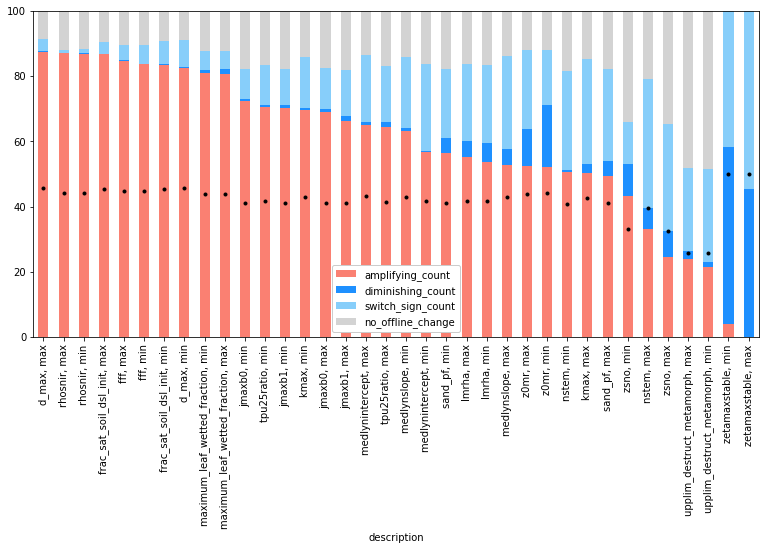

In [439]:
#plt.figure()
crosswalk_sorted.plot.bar(y=['amplifying_count',
                             #'no_offline_change_butwarms',
                      'diminishing_count',
                             #'no_offline_change_butcools',
                      'switch_sign_count',
                      'no_offline_change'
                            ], x='description',stacked=True,
                  colors=['salmon','dodgerblue','lightskyblue','lightgrey'],
                         # alpha=[1,1,1,1,0.2,0.2],
                  figsize=(13,6))
plt.ylim([0,100])
plt.plot(np.arange(0,36),half_of_change,'.k')
plt.legend(framealpha=1)

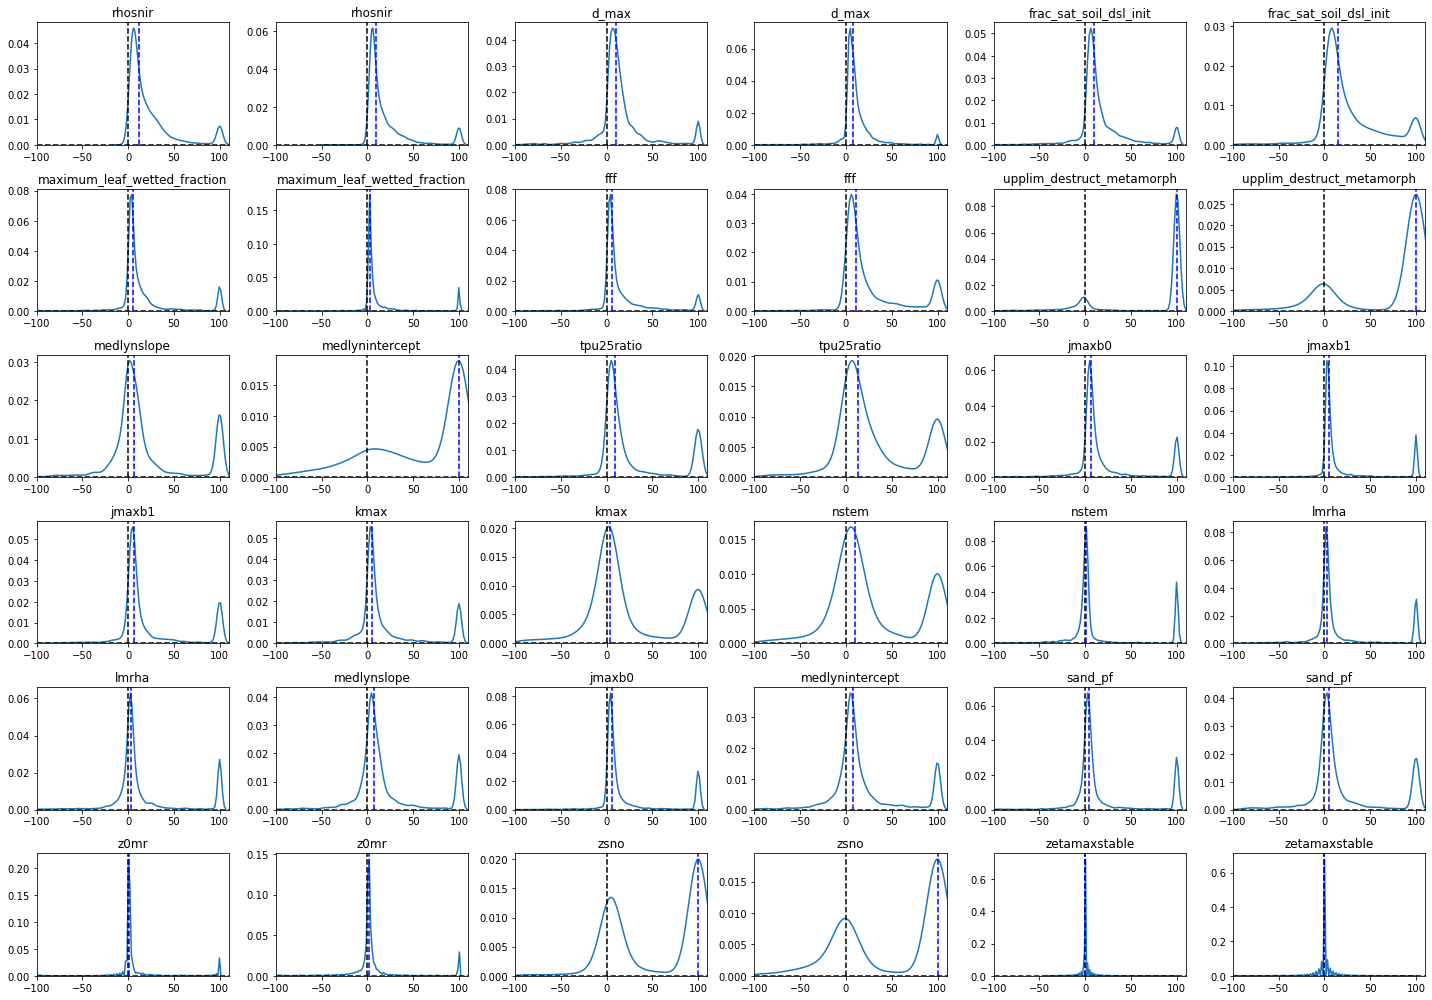

In [343]:
#0-13, 14-34
# 13, 34-36
plt.figure(figsize=(20,14))
for i in np.arange(0,36):
    plt.subplot(6,6,i+1)
    ratio=(delta_Ts_coupled/delta_Ts_offline)[:,:,i]
    ratio_cutoff=ratio.where(np.abs(ratio)<=100,100).where(np.abs(ratio)>=-100,-100).where(~np.isnan(ratio)).where(np.abs(ratio_cutoff.lat)<=60)
    ratio_cutoff_flat=ratio_cutoff.values.flatten()
    ratio=ratio_cutoff_flat
    ratio_nonan=ratio[~np.isnan(ratio)&np.isfinite(ratio)]

    sns.distplot(ratio_nonan, hist=False)#, bins=np.arange(-100,100,10))
    plt.axvline(x=0,linestyle='--',color='k')
    plt.axhline(y=0,linestyle='--',color='k')
    plt.xlim([-100,110])
    plt.tight_layout()
    plt.axvline(x=np.nanmedian(ratio_nonan),linestyle='--',color='b')
    plt.title(crosswalk.param.values[i])
plt.tight_layout()
#plt.ylim([0,0.1])

### Scatter plots

##### Plot correlations globally

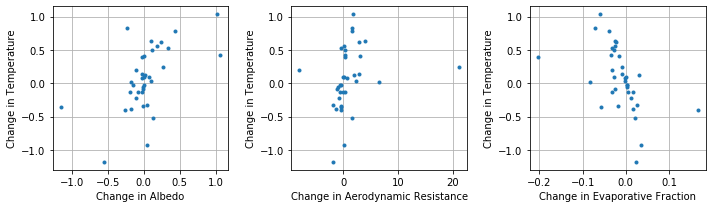

In [73]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot((deltas_Rnet_offline*landweights).mean(dim=['lat','lon']),
         (delta_Ts_coupled*landweights).mean(dim=['lat','lon']),'.')
plt.xlabel('Change in Albedo')
plt.ylabel('Change in Temperature')
plt.grid()

plt.subplot(1,3,2)
plt.plot((deltas_ra_offline*landweights).mean(dim=['lat','lon']),
         (delta_Ts_coupled*landweights).mean(dim=['lat','lon']),'.')
plt.xlabel('Change in Aerodynamic Resistance')
plt.ylabel('Change in Temperature')
plt.grid()

plt.subplot(1,3,3)
plt.plot((delta_EF_offline*landweights).mean(dim=['lat','lon']),
         (delta_Ts_coupled*landweights).mean(dim=['lat','lon']),'.')
plt.xlabel('Change in Evaporative Fraction')
plt.ylabel('Change in Temperature')
plt.grid()

plt.tight_layout()

##### Plot correlations for a single point

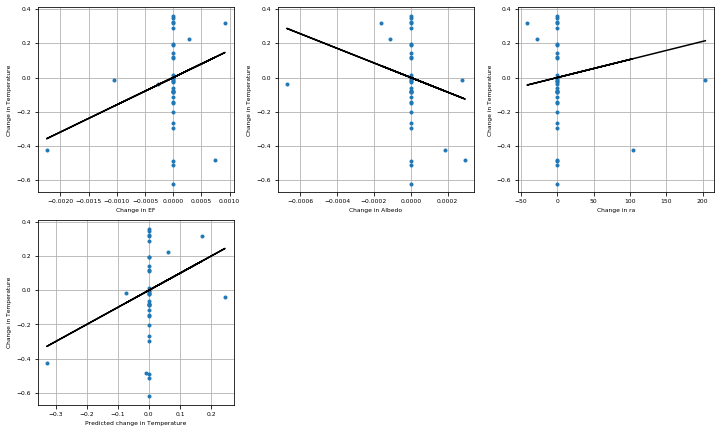

In [204]:
i=0
j=0

y_pred=(corrcoeff_1[i,j]*var1[i,j]+
        corrcoeff_2[i,j]*var2[i,j]+
        corrcoeff_3[i,j]*var3[i,j])

plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.plot((var1[i,j,:]),
         (delta_Ts_coupled[i,j,:]),'.')
plt.plot((var1[i,j,:]),
         (corrcoeff_1[i,j]*var1[i,j,:]),'-k')
plt.xlabel('Change in EF')
plt.ylabel('Change in Temperature')
plt.grid()

plt.subplot(2,3,2)
plt.plot((var2[i,j,:]),
         (delta_Ts_coupled[i,j,:]),'.')
plt.plot((var2[i,j,:]),
         (corrcoeff_2[i,j]*var2[i,j,:]),'-k')
plt.xlabel('Change in Albedo')
plt.ylabel('Change in Temperature')
plt.grid()

plt.subplot(2,3,3)
plt.plot((var3[i,j,:]),
         (delta_Ts_coupled[i,j,:]),'.')
plt.plot((var3[i,j,:]),
         (corrcoeff_3[i,j]*var3[i,j,:]),'-k')
plt.xlabel('Change in ra')
plt.ylabel('Change in Temperature')
plt.grid()


plt.subplot(2,3,4)
plt.plot((y_pred),
         (delta_Ts_coupled[i,j,:]),'.')
plt.plot((y_pred),
         (y_pred),'-k')
plt.xlabel('Predicted change in Temperature')
plt.ylabel('Change in Temperature')
plt.grid()

plt.tight_layout()

##### Correlations between variables at a single point

In [174]:
np.corrcoef(var1, var2)

ValueError: m has more than 2 dimensions

In [165]:
np.corrcoef()

array([[ 1.        , -0.04558747],
       [-0.04558747,  1.        ]])

### Do offline regression

In [31]:
R2s_offline=np.zeros(np.shape(delta_EF_offline[:,:,0]))
R2s_offline[:]=np.nan

corrcoeff_1_offline=np.zeros(np.shape(delta_EF_offline[:,:,0]))
corrcoeff_1_offline[:]=np.nan

corrcoeff_2_offline=np.zeros(np.shape(delta_EF_offline[:,:,0]))
corrcoeff_2_offline[:]=np.nan

corrcoeff_3_offline=np.zeros(np.shape(delta_EF_offline[:,:,0]))
corrcoeff_3_offline[:]=np.nan

In [102]:
reglists_offline=[]
for i in np.arange(0,96):
    print(i)
    reglist=[]
    for j in np.arange(0,144):
        #print(j)
        if ~np.isnan(landfrac[i,j].values):
            nancount=0
            if nancount>0:
                #print('skip')
                reglist.append(np.nan)
                
            else:
                X = np.transpose(np.array([deltas_Rnet_offline[i,j,:-2],
                                           deltas_ra_offline[i,j,:-2],
                                           delta_EF_offline[i,j,:-2]
                                  ]))
                y = delta_Ts_offline[i,j,:-2] #delta_Ts_coupled #delta_Ts_offline#

                # Create an instance of the LinearRegression class
                reg = LinearRegression()

                # Fit the model to the data
                reg.fit(X, y)

                # Print the coefficients of the model
                corrcoeff_1_offline[i,j]=reg.coef_[0]
                corrcoeff_2_offline[i,j]=reg.coef_[1]
                corrcoeff_3_offline[i,j]=reg.coef_[2]
                #for k in (reg.coef_):
                #    print(k)

                y_pred=reg.predict(X)

                #print('R2')
                R2=(reg.score(X, y))
                R2s_offline[i,j]=R2

                reglist.append(reg)
        else:
            reglist.append(np.nan)
    reglists_offline.append(reglist)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


* multiple linear regression
* nonparametric recursive partitioning and regression method (Brei- man et al. 1984) to identify the most important land surface parameter for DTANN

In [39]:
from sklearn.linear_model import LinearRegression
import numpy as np
 
# Assume you have independent variables X and a dependent variable y
X = np.transpose(np.array([#GLOBAL AVERAGE OF CHANGES
                           delta_EF_offline,
                           delta_albedo_offline,
                           deltas_ra_offline,
                           
                           # CHANGES IN GLOBAL AVERAGES
                           #deltas_EF, 
                           #deltas_albedo, 
                           #deltas_htop,
    
    
                           #delta_Ts_offline
                          ]))
y = deltas_Ts_coupled #delta_Ts_coupled #delta_Ts_offline#

X=X#[:-2,:]
y=y#[:-2]
 
# Create an instance of the LinearRegression class
reg = LinearRegression()
 
# Fit the model to the data
reg.fit(X, y)
 
# Print the coefficients of the model
for i in (reg.coef_):
    print(i)
    
y_pred=reg.predict(X)

print('R2')
print(reg.score(X, y))

KeyboardInterrupt: 

In [44]:
FSA_global=(da_FSA_offline*landweights).mean(dim=['lat','lon'])
FSDS_global=(da_FSDS_offline*landweights).mean(dim=['lat','lon'])
FSR_global=FSDS_global-FSA_global
albedo_global=(FSR_global/FSDS_global)

SH_global=(da_SH_offline*landweights).mean(dim=['lat','lon'])
LH_global=(da_LH_offline*landweights).mean(dim=['lat','lon'])
EF_global=(LH_global/(SH_global+LH_global))

HTOP_global=((da_HTOP_offline*landweights).mean(dim=['lat','lon']))

Ts_global=((da_Ts_coupled*landweights).mean(dim=['lat','lon']))

In [45]:
# Albedo
FSR_offline_ref = FSDS_offline_ref-FSA_offline_ref
albedo_ref_offline_global=((FSR_offline_ref*landweights).mean(dim=['lat','lon'])/
                           (FSDS_offline_ref*landweights).mean(dim=['lat','lon']))

# Evaporative fraction
LH_offline_ref_global=(LH_offline_ref*landweights).mean(dim=['lat','lon'])
SH_offline_ref_global=(SH_offline_ref*landweights).mean(dim=['lat','lon'])
EF_offline_ref_global=LH_offline_ref_global/(LH_offline_ref_global+SH_offline_ref_global)


In [46]:
delta_Ts_global=Ts_global-(Ts_coupled_ref*landweights).mean(dim=['lat','lon'])
delta_HTOP_global=HTOP_global-(HTOP_offline_ref*landweights).mean(dim=['lat','lon'])
delta_EF_global=EF_global-EF_offline_ref_global
delta_albedo_global=albedo_global-albedo_ref_offline_global

In [47]:
delta_ra_global=(deltas_ra_offline*landweights).mean(dim=['lat','lon'])

In [48]:
d = {"EF": delta_EF_global, "ra": delta_ra_global, "albedo": delta_albedo_global,
    "Ts":delta_Ts_global}
df = pd.DataFrame(d)

In [64]:
colors=['goldenrod', 'goldenrod', 'skyblue', 'skyblue',
       'skyblue', 'skyblue',
       '#6CD2E9',
       '#6CD2E9', 'skyblue', 'skyblue',
       '#F8CBAD', '#F8CBAD',
       'forestgreen', 'forestgreen', 'lightseagreen',
       'lightseagreen', 'lightseagreen', 'lightseagreen', 'lightseagreen',
       'forestgreen', 'forestgreen', 'orange', 'orange', 'lightgreen',
       'lightgreen', 'forestgreen', 'lightseagreen',
       'forestgreen', 'skyblue', 'skyblue',
       'purple', 'purple', 'purple', 'purple',
       'purple', 'purple']

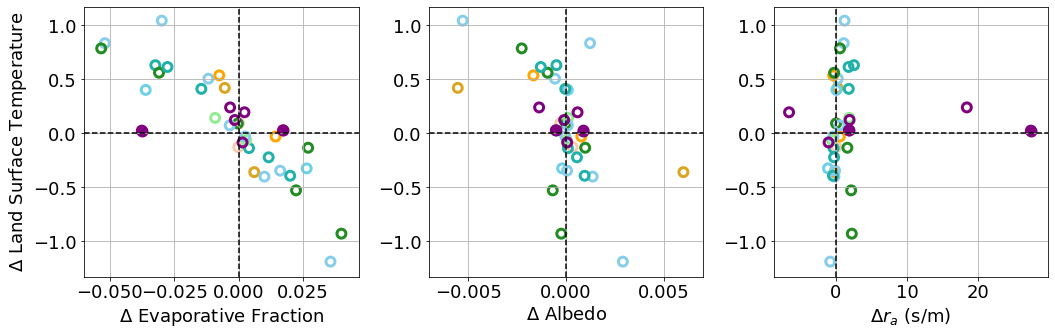

In [69]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
for i, d in enumerate(df.EF):
    plt.scatter(df.EF[i], df.Ts[i],s=80,facecolors='none',linewidths=3, color=colors[i])
    if i>33:
        plt.scatter(df.EF[i], df.Ts[i],s=80,linewidths=3, color=colors[i])
plt.grid()
plt.xlabel('$\Delta$ Evaporative Fraction')
plt.ylabel('$\Delta$ Land Surface Temperature')

plt.subplot(1,3,2)
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
for i, d in enumerate(df.albedo):
    plt.scatter(df.albedo[i], df.Ts[i],s=80,facecolors='none',linewidths=3, color=colors[i])
    if i>33:
        plt.scatter(df.albedo[i], df.Ts[i],s=80,linewidths=3, color=colors[i])
plt.grid()
plt.xlim([-0.007,0.007])
plt.xlabel('$\Delta$ Albedo')

plt.subplot(1,3,3)
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')
for i, d in enumerate(df.ra):
    plt.scatter(df.ra[i], df.Ts[i],s=80,facecolors='none',linewidths=3, color=colors[i])
    if i>33:
        plt.scatter(df.ra[i], df.Ts[i],s=80,linewidths=3, color=colors[i])
plt.grid()

plt.xlabel('$\Delta r_a$ (s/m)')
plt.tight_layout()

<xarray.DataArray (ensemble_key: 36)>
array([ 1.980628e-01, -2.430291e-01, -2.374623e-01,  1.189182e+00,
       -8.214214e-01,  2.387400e-01,  4.497602e-02, -1.131907e+00,
        1.078152e+00, -1.469735e-01, -5.416100e-03,  3.321514e-02,
        2.122388e+00, -1.485270e-03,  1.785354e+00, -3.480288e-01,
       -4.319773e-01,  2.514068e+00, -2.800756e-01,  5.496712e-01,
        1.590702e+00, -4.067461e-01,  5.234171e-01,  1.852069e+00,
       -6.093350e-01, -2.657363e-01,  1.762412e+00,  2.212892e+00,
        4.934935e-01, -3.720536e-01,  1.899252e+00, -1.051381e+00,
        1.839238e+01, -6.613685e+00,  1.799401e+00,  2.740289e+01])
Coordinates:
  * ensemble_key  (ensemble_key) object '0001' '0037' '0007' ... '0011' '0012'

In [52]:
lm.rsquared
#all 0.8494149778886609
# remove EF = 0.3229323408804433
# remove albedo = 0.76
# remove ra = 0.831063
# EF only = 0.73865
# ra only = 0.0081
# albedo only = 0.319

# albedo: 
0.319 (only)
0.089 (marginal)

# EF:
0.73865 (only)
0.526 (marginal)

#ra
0.008 (only)
0.018 (marginal)

0.8494149778886609

In [66]:
0.8494149778886609-0.8310636913762021

0.018351286512458875

In [67]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

lm = ols('Ts ~ ra -1',df).fit()
lm.params
lm.rsquared

0.008166937282046871

In [36]:
lm = ols('Ts ~ albedo + EF + ra -1',df).fit()
anova_table = anova_lm(lm)

NameError: name 'ols' is not defined

In [116]:
var = 'HTOP'
lm = ols('Ts ~ albedo + EF + ra -1',df).fit()
anova_table = anova_lm(lm)
print(np.round(anova_table.loc[var,'sum_sq'] / anova_table['sum_sq'].sum(),4))
lm = ols('Ts ~ albedo + HTOP + EF -1',df).fit()
anova_table = anova_lm(lm)
print(np.round(anova_table.loc[var,'sum_sq'] / anova_table['sum_sq'].sum(),4))
lm = ols('Ts ~ HTOP + EF + albedo -1',df).fit()
anova_table = anova_lm(lm)
print(np.round(anova_table.loc[var,'sum_sq'] / anova_table['sum_sq'].sum(),4))
lm = ols('Ts ~ HTOP + albedo + EF -1',df).fit()
anova_table = anova_lm(lm)
print(np.round(anova_table.loc[var,'sum_sq'] / anova_table['sum_sq'].sum(),4))
lm = ols('Ts ~ EF + albedo + HTOP -1',df).fit()
anova_table = anova_lm(lm)
print(np.round(anova_table.loc[var,'sum_sq'] / anova_table['sum_sq'].sum(),4))
lm = ols('Ts ~ EF + HTOP + albedo -1',df).fit()
anova_table = anova_lm(lm)
print(np.round(anova_table.loc[var,'sum_sq'] / anova_table['sum_sq'].sum(),4))

0.0005
0.0002
0.0039
0.0039
0.0005
0.0023


In [109]:
EF, albedo, HTOP
EF, HTOP, albedo
albedo, EF, HTOP
albedo, HTOP, albedo
HTOP, EF, albedo
HTOP, albedo, EF

,df,sum_sq,mean_sq,F,PR(>F)
albedo,1.0,2.564116,2.564116,62.573768,4.026527e-09
EF,1.0,4.108438,4.108438,100.260841,1.567001e-11
HTOP,1.0,0.004121,0.004121,0.100565,7.531504e-01
Residual,33.0,1.352257,0.040977,NaN,NaN


In [110]:
np.round(anova_table['sum_sq'][:-1].sum() / anova_table['sum_sq'].sum(),4)

0.8316

0.5117

In [ ]:
anova_table.loc['EF','sum_sq'] / anova_table['sum_sq'].sum()

In [ ]:

Intercept    -0.740399
x1            8.333699
x2           29.171750
x3           26.629401
x4           -1.824458

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
 
# Assume you have independent variables X and a dependent variable y
X2 = np.transpose(np.array([#GLOBAL AVERAGE OF CHANGES
                           #deltas_EF_local,
                           #delta_albedos_local,
                           #deltas_htops_local,
                           
                           # CHANGES IN GLOBAL AVERAGES
                           #deltas_EF, 
                           #deltas_albedo, 
                           #deltas_htop,
    
    
                           deltas_Ts_offline
                          ]))
y2 = deltas_Ts_coupled #delta_Ts_coupled #delta_Ts_offline#

X2=X2[:-2,:]
y2=y2[:-2]
 
# Create an instance of the LinearRegression class
reg = LinearRegression()
 
# Fit the model to the data
reg.fit(X2, y2)
 
# Print the coefficients of the model
for i in (reg.coef_):
    print(i)
    
y_pred2=reg.predict(X2)

print('R2')
print(reg.score(X2, y2))

In [ ]:
np.unique(crosswalk.param.values)

* delta_EF (0.728 alone, marginal is 0.553)
* delta_albedo (0.275 alone, marginal is 0.097)
* delta_htop (0.05 alone, marginal is 5.67e-5)

In [ ]:
['z0mr',
 'zsno',
 'upplim_destruct_metamorph',
 'rhosnir',
 'lmrha',
 'zetamaxstable',
 'nstem',
 'sand_pf',
 'tpu25ratio',
 'd_max',
 'frac_sat_soil_dsl_init',
 'jmaxb1',
 'jmaxb0',
 'maximum_leaf_wetted_fraction',
 'medlynintercept',
 'fff',
 'medlynslope',
 'kmax']

In [93]:
for i, ypredi in enumerate(y_pred):
    print(crosswalk.description.values[i])
    #print(ypredi)
    print(y_pred[i])

rhosnir, min
0.56216764
rhosnir, max
-0.6074316
d_max, min
-0.28194532
d_max, max
0.9044318
frac_sat_soil_dsl_init, min
-0.8345013
frac_sat_soil_dsl_init, max
0.24105975
maximum_leaf_wetted_fraction, min
0.5366697
maximum_leaf_wetted_fraction, max
-0.4342185
fff, min
0.74375784
fff, max
-0.29476994
upplim_destruct_metamorph, min
0.04224432
upplim_destruct_metamorph, max
-0.06007965
medlynslope, max
-0.40883744
medlynintercept, min
0.006069281
tpu25ratio, min
0.31210244
tpu25ratio, max
-0.08980602
jmaxb0, max
-0.40910658
jmaxb1, min
0.587478
jmaxb1, max
-0.25072366
kmax, min
0.950741
kmax, max
-0.39758506
nstem, min
0.3994997
nstem, max
-0.2625156
lmrha, min
0.19879076
lmrha, max
-0.067347586
medlynslope, min
0.55660975
jmaxb0, min
0.5392053
medlynintercept, max
-0.68239707
sand_pf, min
0.058667105
sand_pf, max
-0.043837085
z0mr, min
0.036356874
z0mr, max
-0.030488987
zsno, min
0.17660552
zsno, max
-0.06813663
zetamaxstable, min
-0.20579919
zetamaxstable, max
0.50251627


(-1.5, 1.5)

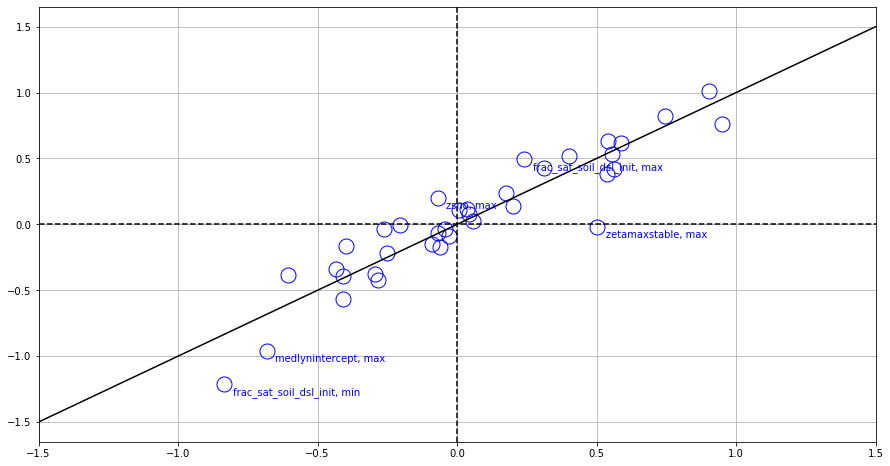

In [84]:
plt.figure(figsize=(15,8))
minval=-1.5#-0.15#np.nanmin(y_pred)*1.1
maxval=1.5# 0.2#np.nanmax(y_pred)*1.1
err=(y_pred-y)
err2=(y_pred2-y2)
#plt.plot(y_pred2, y2,'o',color='firebrick',fillstyle='none', markersize=10, label='Offline')
plt.plot(y_pred, y,'ob',fillstyle='none', markersize=15, label='Coupled')

plt.plot([minval, maxval], [minval, maxval],'-k')
plt.axvline(x=0, linestyle='--',color='k')
plt.axhline(y=0, linestyle='--',color='k')
for i, text in enumerate(crosswalk.description.values):
    if np.abs(err[i])>0.25:
        plt.text(y_pred[i]+0.03, y[i]-0.08, text,color='blue')
    #if np.abs(err2[i])>0.25:
    #    plt.text(y_pred2[i]+0.03, y2[i]-0.08, text,color='firebrick')
        #plt.text(y_pred[i], y[i], text,color='gray')
plt.grid()
plt.xlim([minval, maxval])

In [85]:
reg.coef_

array([5.6903186], dtype=float32)

(-1.5, 1.5)

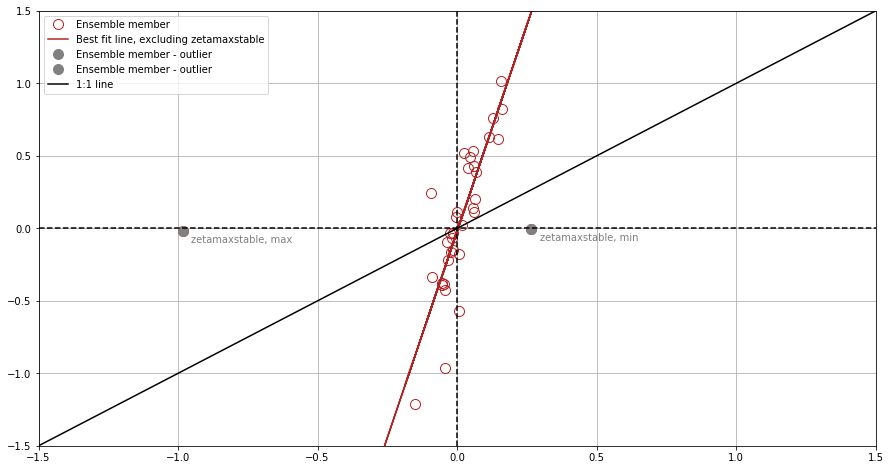

In [82]:
plt.figure(figsize=(15,8))
minval=-1.5#-0.15#np.nanmin(y_pred)*1.1
maxval=1.5# 0.2#np.nanmax(y_pred)*1.1
err=(y_pred-y)
err2=(y_pred2-y2)
plt.plot(deltas_Ts_offline, deltas_Ts_coupled,'o',color='firebrick',fillstyle='none', markersize=10, label='Ensemble member')
y_pred2=reg.predict(X2*2)
plt.plot(X2*2, y_pred2,'-',color='firebrick', label='Best fit line, excluding zetamaxstable')

#plt.plot(y_pred, y,'ob',fillstyle='none', markersize=15, label='Coupled')
for i, text in enumerate(crosswalk.description.values):
    if np.abs(deltas_Ts_offline[i])>0.25:
        plt.text(deltas_Ts_offline[i]+0.03, deltas_Ts_coupled[i]-0.08, text,color='gray')
        plt.plot(deltas_Ts_offline[i], deltas_Ts_coupled[i],'o', color='gray', markersize=10, label='Ensemble member - outlier')
    #if np.abs(err2[i])>0.25:
    #    plt.text(y_pred2[i]+0.03, y2[i]-0.08, text,color='firebrick')
        #plt.text(y_pred[i], y[i], text,color='gray')

plt.plot([minval, maxval], [minval, maxval],'-k', label='1:1 line')
plt.axvline(x=0, linestyle='--',color='k')
plt.axhline(y=0, linestyle='--',color='k')
plt.legend()
plt.grid()
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])

In [ ]:
deltas_Ts_offline

In [ ]:
y_pred

# Figures

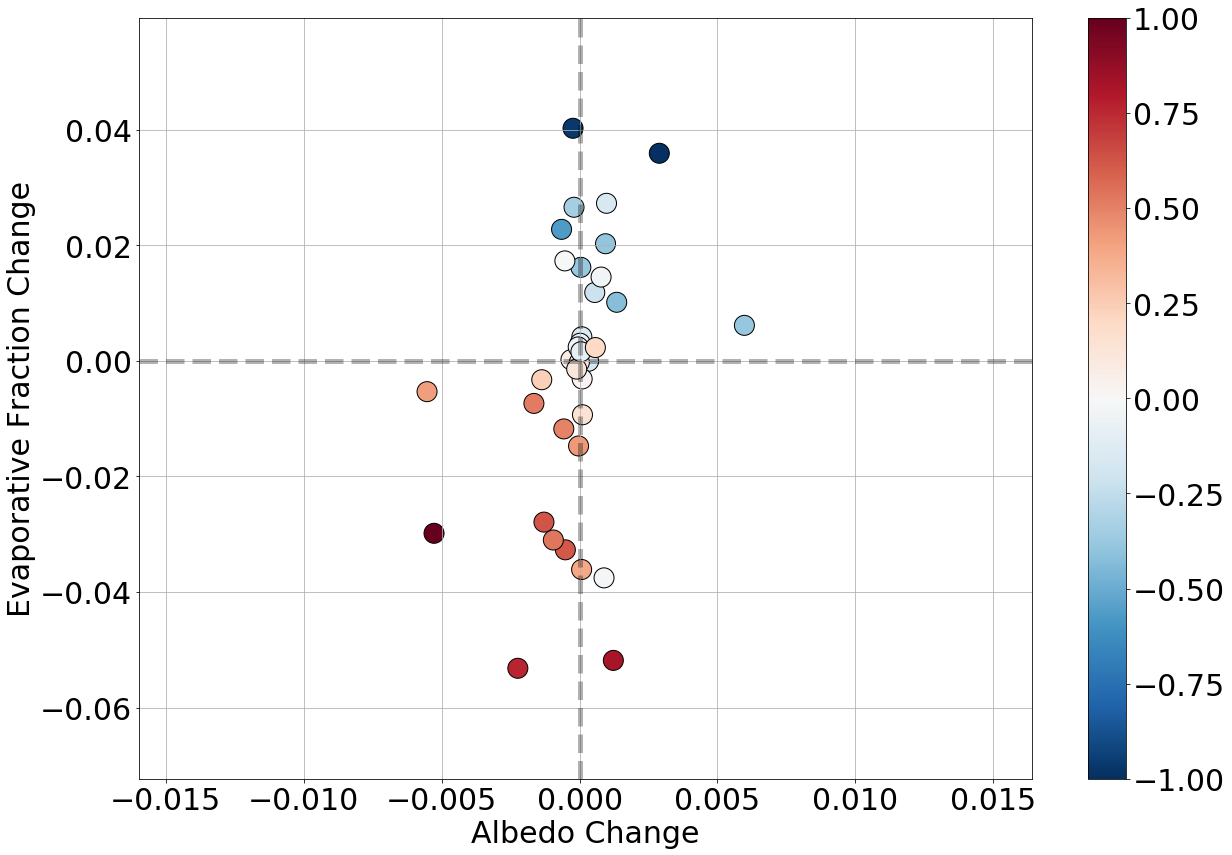

In [289]:
plt.figure(figsize=(20,14))
plt.rcParams.update({'font.size': 30})
plt.scatter(deltas_albedo,
         deltas_EF,
            c=delta_Ts, 
            cmap=plt.cm.RdBu_r, vmin=-1, vmax=1, edgecolor='k',s=400)
plt.axhline(y=0,linestyle='--',color='k',linewidth=5, alpha=0.3)
plt.axvline(x=0,linestyle='--',color='k',linewidth=5, alpha=0.3)
#for i,param in enumerate(crosswalk.param.values):
#    plt.text(delta_albedo[i],delta_EF[i],param)
"""
for i, param in enumerate(crosswalk.param.values):
    if crosswalk.description.values[i]=='zetamaxstable, max':
        plt.annotate( param,(delta_albedo[i]+0.0002,
                     delta_EF[i]-0.002), alpha=0.8)
    elif np.abs(delta_EF[i])>0.02:
        plt.annotate( param,(delta_albedo[i]+0.0002,
                     delta_EF[i]), alpha=0.8)
    elif np.abs(delta_albedo[i])>0.005:
        plt.annotate( param,(delta_albedo[i]+0.0002,
                     delta_EF[i]), alpha=0.8)
                     """
plt.ylabel('Evaporative Fraction Change')
plt.colorbar()
#plt.xlim([-0.01,0.01])
plt.grid()
plt.xlabel('Albedo Change')
plt.savefig('Albedo_vs_EF.png')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

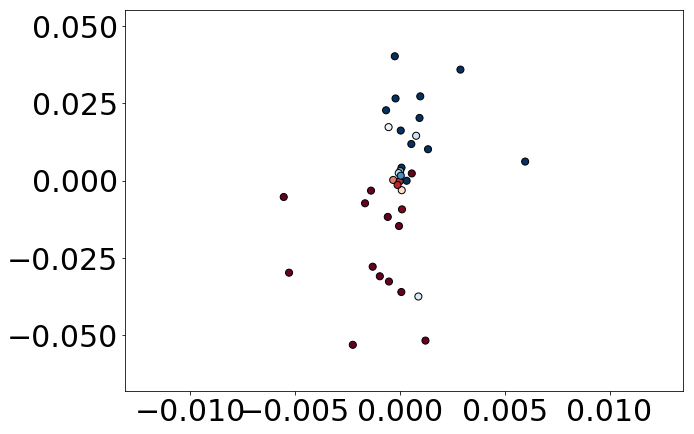

In [291]:
plt.figure(figsize=(10,7))
plt.scatter(deltas_albedo,
         deltas_EF,
            c=delta_Ts, 
            cmap=plt.cm.RdBu_r, vmin=-0.15, vmax=0.15, edgecolor='k',s=50)
#for i,param in enumerate(crosswalk.param.values):
#    plt.text(delta_albedo[i],delta_EF[i],param)
for i, param in enumerate(crosswalk.param.values):
    if crosswalk.description.values[i]=='zetamaxstable, max':
        plt.annotate( param,(delta_albedo[i]+0.0002,
                     delta_EF[i]-0.002), alpha=0.8)
    elif np.abs(delta_EF[i])>0.02:
        plt.annotate( param,(delta_albedo[i]+0.0002,
                     delta_EF[i]), alpha=0.8)
    elif np.abs(delta_albedo[i])>0.005:
        plt.annotate( param,(delta_albedo[i]+0.0002,
                     delta_EF[i]), alpha=0.8)
plt.axhline(y=0,linestyle='--',color='k', alpha=0.3)
plt.axvline(x=0,linestyle='--',color='k', alpha=0.3)
plt.ylabel('Evaporative Fraction Change')
plt.colorbar()
plt.xlim([-0.01,0.01])
plt.grid()
plt.xlabel('Albedo Change')

Text(0, 0.5, 'Temperature Change')

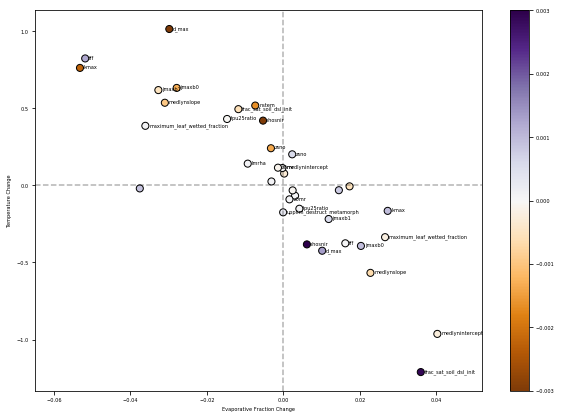

In [295]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 5})
plt.scatter(
         deltas_EF,
            delta_Ts, 
    c=deltas_albedo,
            cmap=plt.cm.PuOr, vmin=-0.003, vmax=0.003, edgecolor='k',s=50)
for i, param in enumerate(crosswalk.param.values):
    if crosswalk.description.values[i]in ['zsno, max','zsno, min',
                                         'z0mr, max']:
        plt.annotate( param,(delta_EF[i]+0.001,
                     delta_Ts[i]-0.005))
    elif np.abs(delta_Ts[i])>0.1:
        plt.annotate( param,(delta_EF[i]+0.001,
                     delta_Ts[i]-0.005))
#for i,param in enumerate(crosswalk.param.values):
#    plt.text(delta_albedo[i],delta_EF[i],param)
plt.axhline(y=0,linestyle='--',color='k', alpha=0.3)
plt.axvline(x=0,linestyle='--',color='k', alpha=0.3)
plt.xlabel('Evaporative Fraction Change')
plt.colorbar()
plt.ylabel('Temperature Change')

In [ ]:
EF changes 

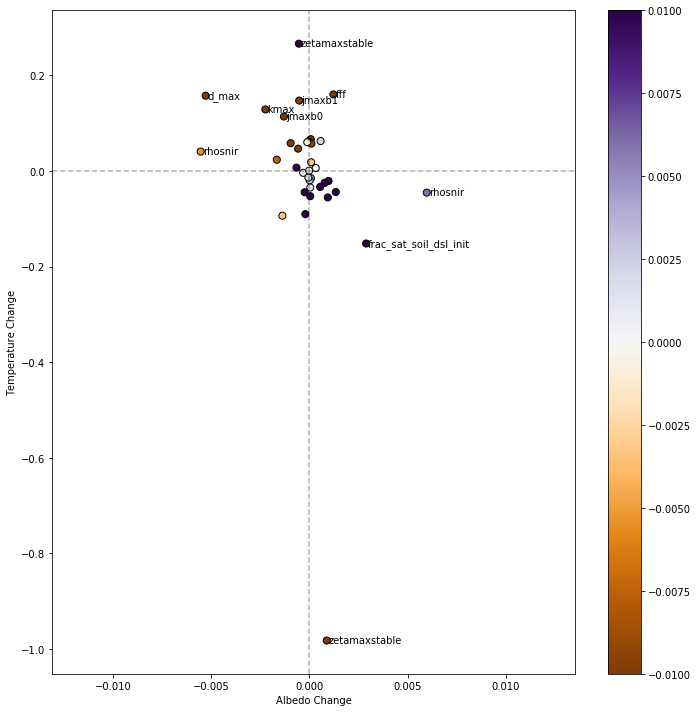

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(
         delta_albedo,
            delta_Ts, 
    c=delta_EF,
            cmap=plt.cm.PuOr, vmin=-0.01, vmax=0.01, edgecolor='k',s=50)
for i, param in enumerate(crosswalk.param.values):
    if np.abs(delta_albedo[i])>0.003:
        plt.annotate( param,(delta_albedo[i]+0.0001,
                     delta_Ts[i]-0.005))
    elif np.abs(delta_Ts[i])>0.1:
        plt.annotate( param,(delta_albedo[i]+0.0001,
                     delta_Ts[i]-0.005))
#for i,param in enumerate(crosswalk.param.values):
#    plt.text(delta_albedo[i],delta_EF[i],param)
plt.axhline(y=0,linestyle='--',color='k', alpha=0.3)
plt.axvline(x=0,linestyle='--',color='k', alpha=0.3)
plt.xlabel('Albedo Change')
plt.colorbar()
plt.ylabel('Temperature Change')
plt.tight_layout()

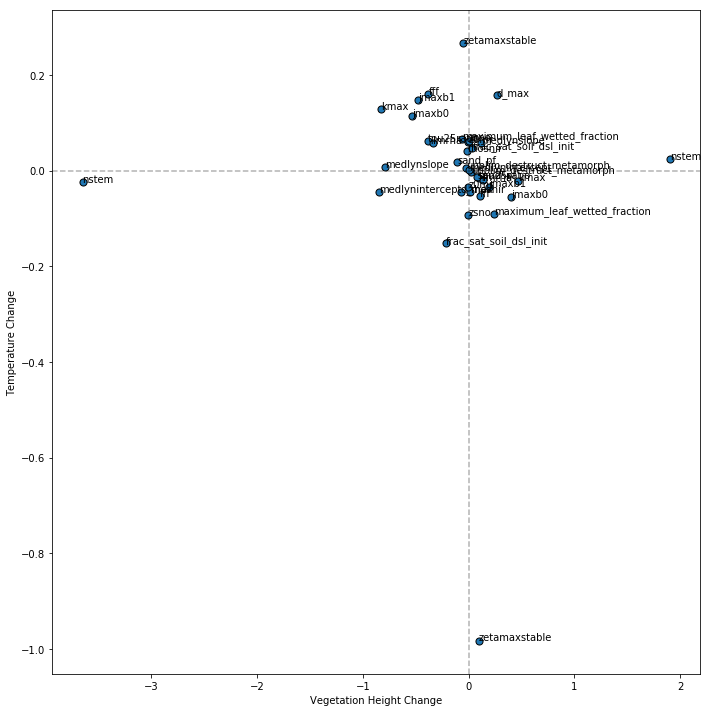

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(
         delta_htop,
            delta_Ts, edgecolor='k',s=50)
for i,param in enumerate(crosswalk.param.values):
    plt.text(delta_htop[i],delta_Ts[i],param)
plt.axhline(y=0,linestyle='--',color='k', alpha=0.3)
plt.axvline(x=0,linestyle='--',color='k', alpha=0.3)
plt.xlabel('Vegetation Height Change')
plt.ylabel('Temperature Change')
plt.tight_layout()

# Compare offline and coupled temperature

In [23]:
landweights.mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(1., dtype=float32)

In [28]:
i=0
temperatures_coupled=[]
temperatures_offline=[]
for i, ds_coupled in enumerate(ensemble_coupled_Ts):
    print(i)
    ds_coupled=ensemble_coupled_Ts[i][var][60*12,:,:]
    global_land_coupled=(ds_coupled*landweights).mean(dim=['lat','lon']).load()
    ds_offline=ensemble_offline_Ts[i][var][60*12,:,:]
    global_land_offline=(ds_offline*landweights).mean(dim=['lat','lon']).load()
    temperatures_coupled.append(global_land_coupled)
    temperatures_offline.append(global_land_offline)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [36]:
ref_temp_coupled=(basecase_lnd_coupled_Ts[var][60*12,:,:]*landweights).mean(dim=['lat','lon']).load()
ref_temp_offline=(basecase_lnd_offline_Ts[var][60*12,:,:]*landweights).mean(dim=['lat','lon']).load()

In [45]:
np.array(temperatures_offline)[:-2]-ref_temp_offline.values

array([ 0.03488159, -0.04003906, -0.04135132,  0.14276123, -0.15246582,
        0.04180908,  0.05307007, -0.07373047,  0.1126709 , -0.03741455,
       -0.019104  ,  0.02902222, -0.00247192,  0.00112915,  0.00964355,
       -0.00692749, -0.03448486,  0.07254028, -0.02374268,  0.10348511,
       -0.01885986,  0.02227783, -0.03259277,  0.00537109, -0.00817871,
        0.03738403,  0.0617981 , -0.06552124,  0.01040649, -0.0105896 ,
        0.04055786, -0.02230835, -0.04043579,  0.05395508], dtype=float32)

In [52]:
x=np.array(temperatures_offline)[:-2]-ref_temp_offline.values
y=np.array(temperatures_coupled)[:-2]-ref_temp_coupled.values

In [58]:
x_reshaped=x.reshape((-1, 1))

In [73]:
model = LinearRegression().fit(x_reshaped,y)
r_sq = model.score(x_reshaped, y)
print(r_sq)

0.5817065951813438


In [61]:
r_sq

0.5817065951813438

In [62]:
model.intercept_

-0.3366982

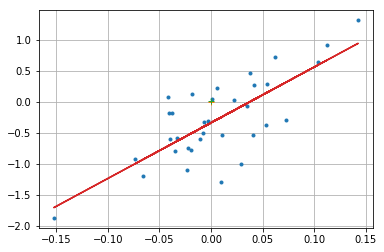

In [64]:
plt.plot(x, y
         ,'.')
plt.plot([0],[0],'+')
plt.plot([0],[ref_temp_coupled.values-ref_temp_offline.values],'+')
plt.plot(x, model.intercept_+(model.coef_*x))
plt.grid()

In [51]:
from sklearn.linear_model import LinearRegression